In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns
from plotting import plot_surf_stat_map
import matplotlib

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def calculate_normals(vertices, faces):
    triangles = vertices[faces]
    face_normals = np.cross( triangles[::,1 ] - triangles[::,0]  , triangles[::,2 ] - triangles[::,0] )
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(vertices.shape, dtype=vertices.dtype)
    vertex_count = np.zeros(vertices.shape[0])
    
    for face in range(faces.shape[0]):
        vertex_normals[faces[face]] += face_normals[face]
        vertex_count[faces[face]] += 1
   
    # divide by actual number of faces
    vertex_normals /= vertex_count[:, np.newaxis]
    
    return vertex_normals

In [4]:
def compare_normals(normals_a, normals_b):
    # normalize normals
    normals_a /= np.linalg.norm(normals_a, axis=1)[:,np.newaxis]
    normals_b /= np.linalg.norm(normals_b, axis=1)[:,np.newaxis]
    
    if np.any(np.isnan(normals_a)):
        raise ValueError('NaN in first set of normals')
    elif np.any(np.isnan(normals_b)):
        raise ValueError('NaN in second set of normals')
    else:
        pass
    
    # calculate angle between each pair of normals in radians
    diff_dot = np.zeros((normals_a.shape[0],))
    diff_rad = np.zeros((normals_a.shape[0],))
    for i in range(normals_a.shape[0]):
        diff_dot[i] = np.dot(normals_a[i], normals_b[i])
    # if the dot product ends up being a very small float point bigger than 1, np.arccos returns NaN
    # therefore set those cases to 1
    diff_dot[np.where(diff_dot>1)] = 1.
    diff_rad = np.arccos(diff_dot)
    
    # transform to degree angle
    diff_deg = diff_rad  * (180/np.pi)
    
    return diff_rad, diff_deg

In [5]:
cutoff_angle=(np.pi/2)
simple_vertices, simple_faces, _ = read_vtk('/scr/ilz3/myelinconnect/groupavg/indv_space/BP4T/lowres_rh_d_def.vtk')
complex_vertices, complex_faces, _ = read_vtk('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/BP4T_rh_mid.vtk')

In [6]:
from bintrees import FastAVLTree
import scipy.spatial as spatial
from utils import log

# calculate normals for simple and complex vertices
simple_normals = calculate_normals(simple_vertices, simple_faces)
complex_normals = calculate_normals(complex_vertices, complex_faces)

# initialize with all vertices and small number of neighbours
remaining_idxs = range(simple_vertices.shape[0])
neighbours = 200

inaccuracy, mapping  = spatial.KDTree(complex_vertices).query(simple_vertices, k=neighbours)

# create tidy long-format lists
simple_idxs = np.asarray([neighbours*[simple_idx] for simple_idx in remaining_idxs]).flatten()
candidate_idxs = mapping.flatten()

# for each vertex pair calculate the angle between their normals
diff_normals, _ = compare_normals(simple_normals[simple_idxs], complex_normals[candidate_idxs])
diff_normals = diff_normals.reshape(mapping.shape)
diff_euclid = inaccuracy

# calculate scores taking into account angle and distance of each vertex pair
scores = (diff_normals-np.nanmean(diff_normals)) + (diff_euclid-np.nanmean(diff_euclid))

# get the candidate with the best score for each vertex (allowing repetitions)
voronoi_seed_idx = mapping[(np.asarray(range(mapping.shape[0])), np.argmin(scores, axis=1))]

In [11]:
np.any(np.isnan(diff_normals))

False

In [19]:
idx = np.argmin(scores, axis=1)

In [49]:
mapping[(np.asarray(range(mapping.shape[0])), np.argmin(scores, axis=1))]

array([  3456,   2946,   2478, ..., 737550, 737722, 738496])

In [47]:
(np.asarray(range(mapping.shape[0])), idx)

(array([    0,     1,     2, ..., 75586, 75587, 75588]),
 array([4, 1, 5, ..., 0, 3, 9]))

In [31]:
np.nanmin(scores[0])

-0.94359597691978303

In [22]:
np.concatenate()

1

In [91]:
plot_outliers = np.zeros(simple_vertices.shape[0],)

In [118]:
np.ones_like(plot_outliers) * np.nan

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [94]:
plot_outliers[np.where(np.isnan(mins))] = 1

In [96]:
sulc = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_sulc.npy')

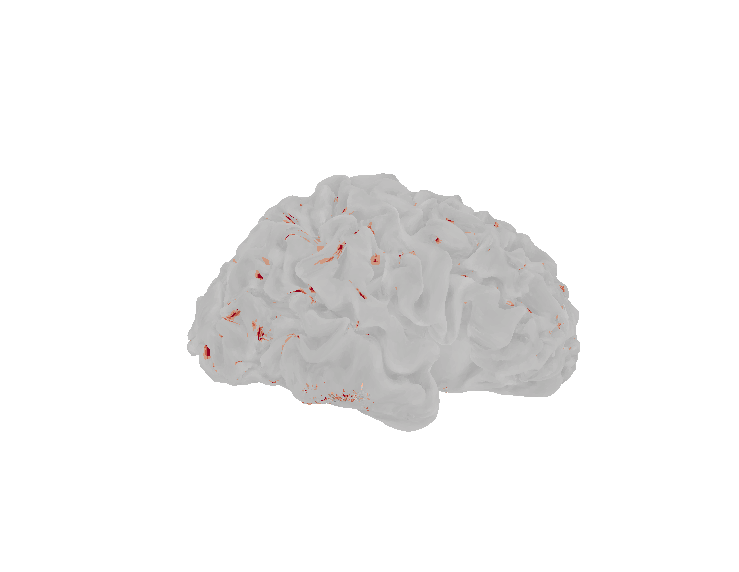

In [98]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_vertices, simple_faces, stat_map=plot_outliers, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.4,elev=180,azim=0, figsize=(13,10))

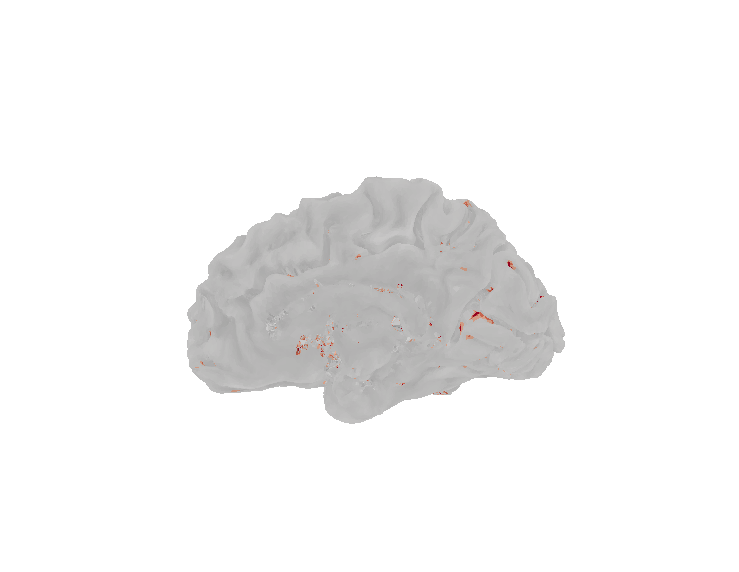

In [100]:
sns.set_style('white')
plot_orig = plot_surf_stat_map(simple_vertices, simple_faces, stat_map=plot_outliers, bg_map=sulc, bg_on_stat=True, 
                               darkness=0.4,elev=180,azim=180, figsize=(13,10))